In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.optim import Adam
from sklearn.preprocessing import StandardScaler


np.random.seed(42) # 乱数生成用のシードを設定
ite = 1 # 乱数生成の回数

# 2次元正規分布の平均ベクトルと共分散行列を設定
original_mean = [5, 5]  # 平均ベクトル
original_cov = [[1, 0.3], [0.3, 1]]  # 共分散行列（相関あり）

random_seed = np.random.randint(0, 10000, ite)  # ランダムな整数値をシード値として取得.例えば 0 〜 9999 の間の整数をite個生成
print("random_seed", random_seed) # 乱数シード値の確認





##################################################################

# 時間埋め込み（正弦波位置エンコーディング）
def pos_encoding(timesteps, output_dim, device='cpu'):
    position = timesteps.view(-1, 1).float()  # 必要に応じて型変換
    div_term = torch.exp(torch.arange(0, output_dim, 2, device=device, dtype=torch.float32) * 
                         (-np.log(10000.0) / output_dim))
    sinusoid = torch.cat([torch.sin(position * div_term), torch.cos(position * div_term)], dim=1)
    return sinusoid

# Dropoutの導入: 過学習を防ぐために、各隠れ層にnn.Dropoutを追加。
# Batch Normalizationの導入: 学習を安定させるためにnn.BatchNorm1dを適用。
# 活性化関数の選択: F.reluの代わりにnn.LeakyReLUやnn.ELUを試すことで、勾配消失問題に対応。

# 拡散モデル
class DiffusionModel(nn.Module):
    def __init__(self, time_embed_dim=16):
        super(DiffusionModel, self).__init__()
        self.time_embed_dim = time_embed_dim  # time_embed_dimをインスタンス変数として初期化
        self.fc1 = nn.Linear(2 + time_embed_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x, t):
        # 時間埋め込み
        t_embed = pos_encoding(t, self.time_embed_dim, x.device)
        x_t = torch.cat([x, t_embed], dim=-1)  # 時間情報と入力データを結合
        x_t = F.relu(self.fc1(x_t))
        x_t = F.relu(self.fc2(x_t))
        return self.fc3(x_t)

# 拡散プロセス
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        t_idx = t - 1 # alphas[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx].view(-1, 1)  # (N, 1)
        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()
        
        t_idx = t - 1 # alphas[0] is for t=1
        alpha = self.alphas[t_idx].view(-1, 1)
        alpha_bar = self.alpha_bars[t_idx].view(-1, 1)
        model.eval()
        with torch.no_grad():
            eps = model(x, t)

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - (1 - alpha) / torch.sqrt(1 - alpha_bar) * eps) / torch.sqrt(alpha)

        return mu
    


random_seed [7270]


############################################
Data_Set_1, Seed: 7270
############################################
data.shape (500, 2)
Epoch 5, Loss: 0.34747678771615026
Epoch 10, Loss: 0.2911638025939465
Epoch 15, Loss: 0.2838657185435295
Epoch 20, Loss: 0.2619251514598727
Epoch 25, Loss: 0.27714280020445586
Epoch 30, Loss: 0.2758849351108074
学習終了


学習時間: 1.93秒


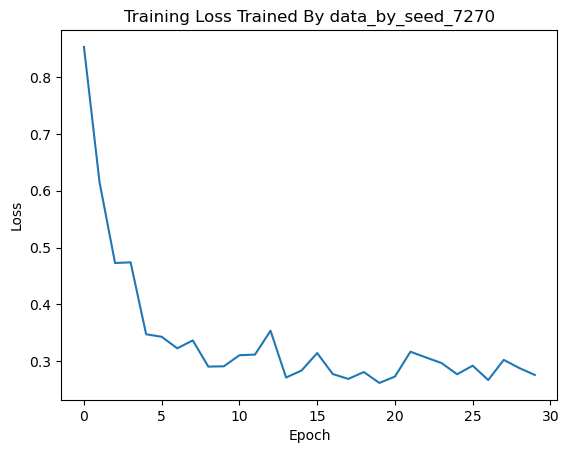



##################################################


--------------------------------------------------
##################################################
Seed: 1
サンプリング開始
generated_data.shape (1000, 50, 2)
サンプリング終了
サンプリング時間: 219.18秒
サンプリング時間: 3.0分 39.180845737457275秒
##################################################
############################################
Random Seed: 7270
############################################
平均ベクトルの平均: [5.001896 4.825415]
共分散行列の平均:
 [[1.42486816e-05 1.07248666e-06]
 [1.07248666e-06 1.59412901e-05]]
相関係数の平均: 0.07273026191381703


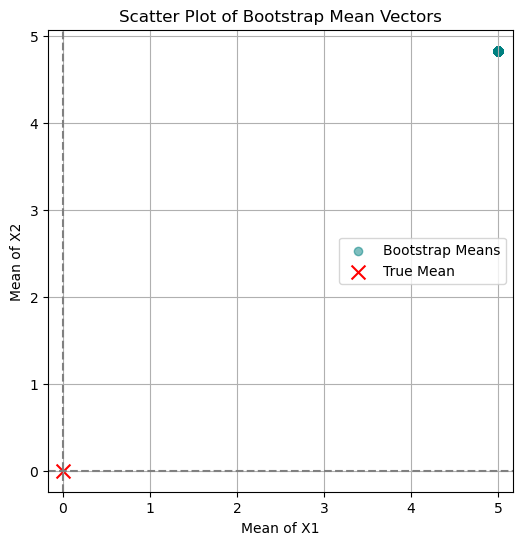

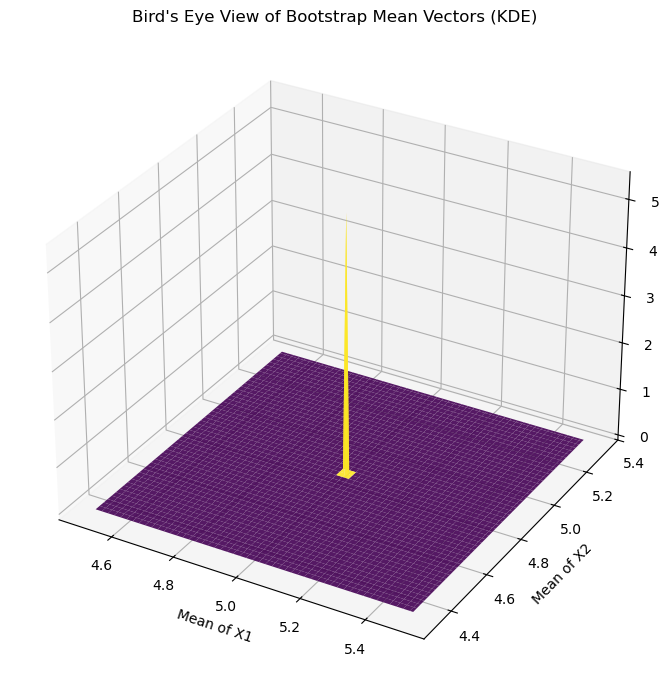

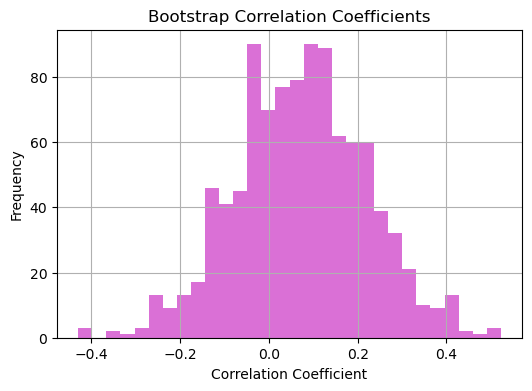

############################################
End
############################################




In [5]:
#########################################################################################################################



# データセットサイズとデータセット数
num_dataset = 1000 # サンプリング回数
dataset_size = 500 # 元データのサイズ 






# ハイパーパラメータ
num_timesteps = 1000 # 拡散ステップ数
epochs = 30          # 学習エポック数
lr = 1e-3            # 学習率
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# シード値の固定
np.random.seed(42)

# サンプリング
iter = 1 #学習元データの数
# シード値の生成
random_seed = np.random.randint(0, 10000, iter)

# モデルとデータを管理する辞書
models = {}
original_datas = {}

for (i, seed) in enumerate(random_seed):
    start_time = time.time() # 計測開始

    # モデルの初期化
    time_embed_dim = 16
    model = DiffusionModel(time_embed_dim=time_embed_dim).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    diffuser = Diffuser(num_timesteps=num_timesteps, device=device)

    # 学習データ(ガウスノイズ)
    print("############################################")
    print(f"Data_Set_{i+1}, Seed: {seed}") # 開始の合図
    print("############################################")
    np.random.seed(seed) # 取得した乱数を新しいシード値として設定
    data = np.random.multivariate_normal(original_mean, original_cov, size=dataset_size) # 学習元データの生成 (50, 2)
    print("data.shape", data.shape) # (50, 2)
    train_data = torch.tensor(data, dtype=torch.float32).to(device)  # shape: (50, 2)

    # データローダー作成
    batch_size = 10
    dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # 学習
    losses = []
    for epoch in range(epochs):
        loss_sum = 0.0
        for batch in dataloader:
            optimizer.zero_grad()
            x = batch.to(device)
            t = torch.randint(1, num_timesteps + 1, (len(x),), device=device)

            x_noisy, noise = diffuser.add_noise(x, t)
            noise_pred = model(x_noisy, t)
            loss = F.mse_loss(noise_pred, noise)

            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
        avg_loss = loss_sum / len(dataloader)
        losses.append(avg_loss)
        # 5の倍数エポックで損失を表示
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}, Loss: {avg_loss}")
    # 辞書に保存
    models[f"model_{i+1}"] = model
    original_datas[f"seed_{seed}"] = data
    print("学習終了")
    end_time = time.time() # 計測終了
    print('\n')
    print(f"学習時間: {end_time - start_time:.2f}秒")

    # 学習曲線のプロット
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Trained By data_by_seed_{}'.format(seed))
    plt.show()
    print('\n')
    print("#"*50)
    print('\n')










# 拡散モデルのサンプリング関数
def generate_samples(model, n=dataset_size, B=num_dataset, device='cpu'):
    # n: 1データセットあたりのサンプル数
    # B: データセットの数
    model.eval()  # 評価モードに設定
    with torch.no_grad():
        new_sample_list = []
        for _ in range(B):
            torch.manual_seed(np.random.randint(0, 10000)) # シード値の固定
            samples = torch.randn((n, 2), device=device) # デノイズ前の乱数データ
            for t in range(num_timesteps, 0, -1): 
                t_tensor = torch.tensor([t] * len(samples), device=device) # 時刻tのテンソル
                samples = diffuser.denoise(model, samples, t_tensor) # ノイズ除去
            samples = samples.cpu().numpy() # numpy配列に変換
            new_sample_list.append(samples) # サンプルをリストに追加
    return new_sample_list


# ブートストラップサンプリングの実行
generated_data_list = []


# 拡散モデルによるサンプリング
for model_key, data, seed, selected_model in zip(original_datas.keys(), original_datas.values(), models.keys(), models.values()):
    print("-"*50)
    print("#"*50)
    print(f"Seed: {seed.split('_')[-1]}")
    print("サンプリング開始")

    start_time = time.time() # 計測開始
    generated_data = generate_samples(selected_model, n=50, B=1000, device=device) # サンプリング実行
    generated_data_list.append(generated_data) # サンプルをリストに追加
    generated_data = np.array(generated_data) # numpy配列に変換
    print("generated_data.shape", generated_data.shape) # (1000, 50, 2)
    end_time = time.time() # 計測終了
    print("サンプリング終了")

    print(f"サンプリング時間: {end_time - start_time:.2f}秒")
    print(f"サンプリング時間: {(end_time - start_time)//60}分 {(end_time - start_time)%60}秒")

    # サンプルされたデータの保存
    # torch.save(generated_data, f"master_research/saved_data/sampled_data/sampled_data_{seed.split('_')[-1]}_epoch_{epochs}.pth")
    print("#"*50)




# サンプリングの可視化
for seed, generated_samples in zip(np.nditer(random_seed), generated_data_list):
    print("############################################")
    print("Random Seed:", seed) # 開始の合図
    print("############################################")

    # ---------------------統計量制御---------------------
    bootstrap_mean_vecs = np.mean(generated_samples, axis=1) # 各ブートストラップサンプルの平均ベクトル（1000, 2）
    bootstrap_cov_mats = np.array([np.cov(sample.T) for sample in generated_samples]) # 各ブートストラップサンプルの共分散行列（1000, 2, 2）
    bootstrap_corr_coefs = np.array([np.corrcoef(sample.T)[0, 1] for sample in generated_samples]) # 各ブートストラップサンプルの相関係数（1000,）

    # サイズの確認
    # print("Bootstrap Mean Vector", bootstrap_mean_vecs.shape) # 平均ベクトル
    # print("Bootstrap Covariance Matrix", bootstrap_cov_mats.shape) # 共分散行列
    # print("Bootstrap Correlation Coefficient", bootstrap_corr_coefs.shape) # 相関係数

    # 代表値を出力
    print("平均ベクトルの平均:", np.mean(bootstrap_mean_vecs, axis=0))
    print("共分散行列の平均:\n", np.mean(bootstrap_cov_mats, axis=0))
    print("相関係数の平均:", np.mean(bootstrap_corr_coefs))

    # 平均ベクトルの分布
    
    plt.figure(figsize=(6, 6))
    plt.scatter(bootstrap_mean_vecs[:, 0], bootstrap_mean_vecs[:, 1], alpha=0.5, color='teal', label='Bootstrap Means')

    # 原点を基準として赤十字
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.scatter(0, 0, color='red', marker='x', s=100, label='True Mean')

    plt.xlabel('Mean of X1')
    plt.ylabel('Mean of X2')
    plt.title('Scatter Plot of Bootstrap Mean Vectors')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()



    from scipy.stats import gaussian_kde
    from mpl_toolkits.mplot3d import Axes3D  # 必要

    # カーネル密度推定
    kde = gaussian_kde(bootstrap_mean_vecs.T)

    # グリッド生成
    x = np.linspace(np.min(bootstrap_mean_vecs[:, 0]) - 0.5, np.max(bootstrap_mean_vecs[:, 0]) + 0.5, 100)
    y = np.linspace(np.min(bootstrap_mean_vecs[:, 1]) - 0.5, np.max(bootstrap_mean_vecs[:, 1]) + 0.5, 100)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = kde(positions).reshape(X.shape)

    # 3Dプロット
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)

    ax.set_xlabel('Mean of X1')
    ax.set_ylabel('Mean of X2')
    ax.set_zlabel('Density')
    ax.set_title('Bird\'s Eye View of Bootstrap Mean Vectors (KDE)')
    plt.tight_layout()
    plt.show()




    # 相関係数の分布
    plt.figure(figsize=(6, 4))
    plt.hist(bootstrap_corr_coefs, bins=30, color='orchid')
    plt.title('Bootstrap Correlation Coefficients')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()




    # 終了の合図
    print("############################################")
    print("End")
    print("############################################")

    # 改行
    print("\n")